# Quantum GAN com Pennylane e MedMNIST

Este notebook apresenta uma implementação simplificada de uma GAN quântica inspirada no método de *patches* descrito por Huang et al. Utilizamos o dataset **MedMNIST** para comparação com os modelos clássicos.

## 1. Setup Quântico
Instalação de `pennylane` e demais bibliotecas necessárias para execução do modelo híbrido.

In [1]:
!pip install pennylane pennylane-lightning torch medmnist matplotlib --quiet
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import medmnist
from medmnist import INFO
import matplotlib.pyplot as plt

from quantum_gan_medmnist import (
    Discriminator,
    PatchQuantumGenerator,
    train_quantum_gan,
    run_experiments,
)


## 2. Preparação do Dataset
Utilizamos o mesmo subset do notebook clássico para permitir comparação direta. Pode ser necessário reduzir a resolução das imagens para se adequar ao número de qubits disponíveis.

In [2]:
# Seleciona o dataset
DATA_FLAG = 'breastmnist'
info = INFO[DATA_FLAG]
download = True

transform_lowres = transforms.Compose([
    transforms.Resize((8, 8)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

transform_highres = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Carrega treino e teste
train_dataset = getattr(medmnist, info['python_class'])(
    split='train', transform=transform_lowres, download=download
)
test_dataset = getattr(medmnist, info['python_class'])(
    split='test', transform=transform_lowres, download=download
)

train_dataset_highres = getattr(medmnist, info['python_class'])(
    split='train', transform=transform_highres, download=download
)
test_dataset_highres = getattr(medmnist, info['python_class'])(
    split='test', transform=transform_highres, download=download
)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Using downloaded and verified file: /home/mahlow/.medmnist/breastmnist.npz
Using downloaded and verified file: /home/mahlow/.medmnist/breastmnist.npz


In [3]:
print(train_dataset)

Dataset BreastMNIST of size 28 (breastmnist)
    Number of datapoints: 546
    Root location: /home/mahlow/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 'normal, benign'}
    Number of samples: {'train': 546, 'val': 78, 'test': 156}
    Description: The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.
    License: CC BY 4.0


In [13]:
# Separa conjuntos por rótulo
from torch.utils.data import DataLoader, Subset

def subset_by_label(dataset, label):
    idx = [i for i in range(len(dataset)) if int(dataset.labels[i]) == label]
    return Subset(dataset, idx)

train_loader_0 = DataLoader(subset_by_label(train_dataset, 0), batch_size=batch_size, shuffle=True)
train_loader_1 = DataLoader(subset_by_label(train_dataset, 1), batch_size=batch_size, shuffle=True)


/tmp/ipykernel_1204445/4186682301.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  idx = [i for i in range(len(dataset)) if int(dataset.labels[i]) == label]


## 3. Implementação da Quantum GAN
Seguimos o tutorial da Pennylane para criar o gerador quântico por patches. O discriminador permanece clássico.

In [5]:
# Configurações do circuito
n_qubits = 5
n_a_qubits = 1
target_img_size = 8
q_depth = 6

patch_size = 2 ** (n_qubits - n_a_qubits)
if (target_img_size ** 2) % patch_size != 0:
    raise ValueError('target_img_size**2 deve ser múltiplo de patch_size para montar a imagem completa')
n_generators = (target_img_size ** 2) // patch_size
latent_dim = n_qubits


## 4. Treinamento
Define a função de perda adversarial e executa um ciclo de treinamento simplificado.

### 4.1 Treinamento separado por classe
Treinamos dois geradores: um para imagens malignas (rótulo 0) e outro para imagens benignas (rótulo 1).

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

G_mal = PatchQuantumGenerator(
    n_generators,
    target_img_size,
    n_qubits=n_qubits,
    n_a_qubits=n_a_qubits,
    q_depth=q_depth,
).to(device)
D_mal = Discriminator(img_size=target_img_size).to(device)
loss_D_mal, loss_G_mal = train_quantum_gan(
    train_loader_0, G_mal, D_mal, epochs=50, device=device
)

G_ben = PatchQuantumGenerator(
    n_generators,
    target_img_size,
    n_qubits=n_qubits,
    n_a_qubits=n_a_qubits,
    q_depth=q_depth,
).to(device)
D_ben = Discriminator(img_size=target_img_size).to(device)
loss_D_ben, loss_G_ben = train_quantum_gan(
    train_loader_1, G_ben, D_ben, epochs=50, device=device
)


Epoch 1: D 1.3811 G 0.5950 - Epoch Time: 99.61s
Epoch 2: D 1.3518 G 0.5992 - Epoch Time: 86.86s
Epoch 3: D 1.3254 G 0.6064 - Epoch Time: 86.17s
Epoch 4: D 1.2894 G 0.6159 - Epoch Time: 86.12s
Epoch 5: D 1.2675 G 0.6198 - Epoch Time: 86.35s
Epoch 6: D 1.2306 G 0.6297 - Epoch Time: 84.79s
Epoch 7: D 1.2006 G 0.6403 - Epoch Time: 84.26s
Epoch 8: D 1.1713 G 0.6493 - Epoch Time: 84.98s
Epoch 9: D 1.1374 G 0.6615 - Epoch Time: 82.91s
Epoch 10: D 1.1081 G 0.6736 - Epoch Time: 81.93s
Epoch 11: D 1.0702 G 0.6876 - Epoch Time: 81.72s
Epoch 12: D 1.0433 G 0.6958 - Epoch Time: 80.90s
Epoch 13: D 1.0032 G 0.7139 - Epoch Time: 82.49s
Epoch 15: D 0.9280 G 0.7492 - Epoch Time: 80.39s
Epoch 16: D 0.8913 G 0.7691 - Epoch Time: 81.81s
Epoch 17: D 0.8491 G 0.7938 - Epoch Time: 81.98s
Epoch 18: D 0.8170 G 0.8158 - Epoch Time: 81.96s
Epoch 19: D 0.7655 G 0.8468 - Epoch Time: 82.74s
Epoch 20: D 0.7463 G 0.8667 - Epoch Time: 80.85s
Epoch 21: D 0.7047 G 0.9032 - Epoch Time: 79.86s
Epoch 22: D 0.6579 G 0.9354 -

### Curvas de Loss

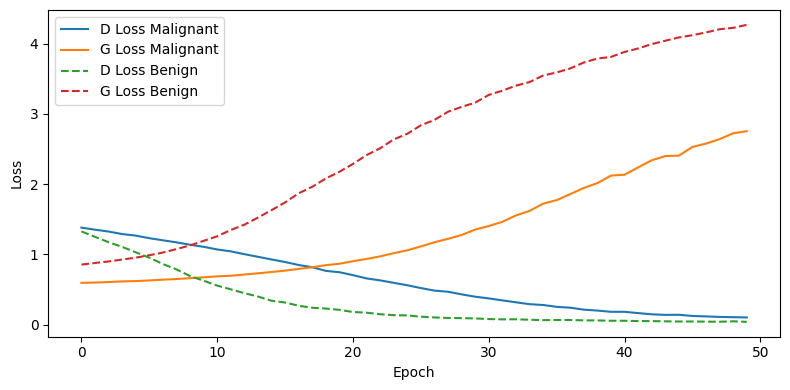

In [16]:
plt.figure(figsize=(8,4))
plt.plot(loss_D_mal, label='D Loss Malignant')
plt.plot(loss_G_mal, label='G Loss Malignant')
plt.plot(loss_D_ben, label='D Loss Benign', linestyle='--')
plt.plot(loss_G_ben, label='G Loss Benign', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


## 5. Avaliação
Utilize as mesmas métricas (FID e IS) para comparar as imagens geradas pela abordagem quântica.

In [17]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore
import pandas as pd

def denormalize(imgs):
    return imgs * 0.5 + 0.5

def evaluate_gan(
    G,
    label_target: int,
    gan_name: str,
    gen_label_name: str,
    test_dataset,
    n_qubits: int,
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu',
    max_batches: float = float('inf')
):
    """
    Avalia um gerador GAN usando FID e Inception Score.

    Correções aplicadas:
      - usa normalize=True tanto em FID quanto em InceptionScore, para aceitar tensores float em [0,1].
      - converte imagens grayscale (1 canal) em RGB (3 canais).
      - redimensiona tudo para 299×299 (requisito do InceptionV3).
    """
    loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # normalize=True: aceita floats em [0,1] e faz o cast interno para uint8
    fid = FrechetInceptionDistance(feature=64, normalize=True).to(device)
    is_metric = InceptionScore(normalize=True).to(device)

    G = G.to(device)
    G.eval()

    count = 0
    for real, labels in loader:
        mask = (labels.squeeze() == label_target)
        if mask.sum() == 0:
            continue

        # real: [B,1,H,W], floats normalizados em [-1,1]
        real = real[mask].to(device)
        real = denormalize(real)
        real = real.repeat(1, 3, 1, 1)  # -> [B,3,H,W]
        real = F.interpolate(real, size=(299, 299), mode='bilinear', align_corners=False)

        b_size = real.size(0)
        noise = torch.rand(b_size, n_qubits, device=device) * (torch.pi / 2)

        with torch.no_grad():
            fake = G(noise)  # supõe saída [B,1,H,W], floats normalizados em [-1,1]
        fake = denormalize(fake)
        fake = fake.to(device)
        fake = fake.repeat(1, 3, 1, 1)  # -> [B,3,H,W]
        fake = F.interpolate(fake, size=(299, 299), mode='bilinear', align_corners=False)

        # atualiza métricas com floats em [0,1]
        fid.update(real, real=True)
        fid.update(fake, real=False)
        is_metric.update(fake)

        count += 1
        if count >= max_batches:
            break

    fid_score = fid.compute().item()
    is_mean, is_std = is_metric.compute()

    return {
        'GAN': gan_name,
        'Generator_Label': gen_label_name,
        'Real_Label': 'Malignant' if label_target == 0 else 'Benign',
        'FID': fid_score,
        'IS_Mean': is_mean.item(),
        'IS_Std': is_std.item()
    }

# Exemplo de uso:
results = []
results.append(evaluate_gan(G_mal, 0, 'QuantumGAN', 'Malignant', test_dataset_highres, n_qubits))
results.append(evaluate_gan(G_ben, 1, 'QuantumGAN', 'Benign',   test_dataset_highres, n_qubits))
results_df = pd.DataFrame(results)
results_df

/home/mahlow/anaconda3/envs/my_env/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


,GAN,Generator_Label,Real_Label,FID,IS_Mean,IS_Std
0,QuantumGAN,Malignant,Malignant,6.338286,1.220420,0.109031
1,QuantumGAN,Benign,Benign,6.716332,1.348282,0.076391


## Classificação com ResNet

In [19]:
G_dict = {'malignant': G_mal, 'benign': G_ben}
classification_results = run_experiments(
    train_dataset_highres,
    test_dataset_highres,
    G_dict,
    latent_dim=latent_dim,
    batch_size=64,
    epochs=5,
    device=device,
)
classification_results


/tmp/ipykernel_1204445/1243825210.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)
/tmp/ipykernel_1204445/1243825210.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)
/tmp/ipykernel_1204445/1243825210.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)
/tmp/ipykernel_1204445/1243825210.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract

,ratio,acc,prec,rec,f1,auc,tn,fp,fn,tp
0,0.0,0.871795,0.898305,0.929825,0.913793,0.822055,30,12,8,106
1,0.25,0.865385,0.890756,0.929825,0.909871,0.810150,29,13,8,106
2,0.5,0.775641,0.915789,0.763158,0.832536,0.786341,34,8,27,87
3,0.75,0.814103,0.863248,0.885965,0.874459,0.752506,26,16,13,101
4,1.0,0.801282,0.837398,0.903509,0.869198,0.713659,22,20,11,103
5,1.5,0.762821,0.896907,0.763158,0.824645,0.762531,32,10,27,87
6,100%_sintético→real,0.653846,0.717391,0.868421,0.785714,0.469925,3,39,15,99
7,100%_sintético_70/30_selftest,1.000000,1.000000,1.000000,1.000000,1.000000,78,0,0,86
